# Code Embeddings using Graph Neural Networks
In this notebook, we will train a (Gated) Graph Neural Network to embed a set of source code snippets. We will do by training the GNN on the OJ-104 dataset. It is compromised of ~28$K$ code snippets written in C with 104 labels. Each label refers to a speficic high level operation such as finding the minimum of a list of integers. The source is written by Siow _et al._ and cloned from their Github repository [link](https://github.com/jingkai92/learning-program-representation). You are highly recommended to go through as it is well written and modular. It can also be helpful to your project (don't forget to properly cite it!)

# Model Architecture

![Model Architecture](./figures/model_arch.png)

Before starting the training, let us first discuss the different components of the training pipeline. As input, we take C code snippets in raw format as we have stated in the beginning. Then we generate Code Property Graphs, referred to as CPGs ([Yamaguchi _et al._](https://ieeexplore.ieee.org/document/6956589)). At a high level, a CPG is a graph that combines the AST, CFG and PDG of a given code. Each node has two attributes: node type and code. Node type can be _Assignment_ if we are dealing with an assignment statement, or _Operator_ and so on. The code attribute holds the snippet of code that the node represents. The graphs are generated using [joern](https://joern.io/), a platform for robust analysis of source code, bytecode, and binary code. In this notebook, we will not be using such tool given that the data included already contains the needed CPGs.

Generating the CPG is not enough to start training since the content of each node is still represented textually. We first need to create an initial vector representation of each node. In this repository an LSTM layer is used to embed text to vectors. Of course, this is not the only way to achieve this. As we have seen during the lecture, we can train a word2vec model on the corpus, and then encode the code of each node using the trained model. Alternatively, we can also use a pretrained CodeBERT, and extract the embeddings from the hidden representations.

Once these initial vectors are generated, the CPG is now fully numerically represented. Specifically, we have three matrices: $V$ of dimension $n\times d$, where $n$ is the number of nodes in the CPG, $d$ is the embedding dimension, in this case it is set to $128$. $E$ of dimension $k \times 1$, where $k$ is the number of edge types. $L$ represents the adjacency list.

With these matrices, we will train a GGNN layer (or more), that will embed the nodes of each CPG. Specifically, each GGNN layer will allow each node to update its internal representation through message-passing, that takes the node's representation and that of its direct neighbours. Now, we are solving a classification task, at this point we still have a matrix ($V$) that has been updated. We need to transform that matrix into a single vector to be passed to the classification layer. In this model, to represent the graph using one vector we taken the mean of its nodes' reprsentations. This operation is called _readout_. Once we performed, the vector is then passed to a Softmax layer and the error is then backpropagated throughout the network.

In [2]:
from pymodels.classification.graph.ggnn import GGNNModel

In [3]:
from configs.config import Config
from factory.dataset_factory import DatasetFactory
from factory.trainer_factory import TrainerFactory

In [4]:
config_path = "./ymls/code_classification/graph/ggnn.yml"

In [5]:
config = Config(config_path)

[20231229-083735][INFO]: GPU ID: 0
[20231229-083735][INFO]: Seed: 4096
[20231229-083735][INFO]: Pytorch Threads: 8


In [6]:
config.setup_vocab_dict()

[20231229-083735][INFO]: Loading dictionary: ./data/poj104/token_vocab_dict.pkl/5170
[20231229-083735][INFO]: Loading dictionary: ./data/poj104/node_vocab_dict.pkl/68


In [7]:
dataset = DatasetFactory().get_dataset(config)

[20231229-083735][INFO]: Dataset: online-judge
[20231229-083735][INFO]: Collate: collate_graph_for_classification
[20231229-083735][INFO]: DataFormatter: MultiEdgeGraphFormatter
[20231229-083735][INFO]: Path: ./data/poj104/train.gzip, Size: 28622, Time: 22.35
[20231229-083735][INFO]: Path: ./data/poj104/val.gzip, Size: 3581, Time: 3.81
[20231229-083735][INFO]: Total Missing Word: 5303


In [8]:
trainer = TrainerFactory().get_trainer(config)

In [9]:
trainer.setup_model()
trainer.start_train(dataset)

[20231229-083735][INFO]: Model: <class 'pymodels.classification.graph.ggnn.GGNNModel'>
[20231229-083735][INFO]: Parameter Count: 1126888
[20231229-083735][INFO]: Class Weights: [0.01507537688442211, 0.06521739130434782, 0.015151515151515152, 0.018691588785046728, 0.03680981595092025, 0.02727272727272727, 0.023346303501945526, 0.016042780748663103, 0.04838709677419355, 0.016129032258064516, 0.023255813953488372, 0.016042780748663103, 0.015306122448979591, 0.03571428571428571, 0.022058823529411766, 0.016483516483516484, 0.0234375, 0.03314917127071823, 0.030612244897959183, 0.018691588785046728, 0.046875, 0.019736842105263157, 0.016129032258064516, 0.034482758620689655, 0.0158311345646438, 0.015113350125944584, 0.07792207792207792, 0.015789473684210527, 0.016129032258064516, 0.015228426395939087, 0.016853932584269662, 0.06451612903225806, 0.015625, 0.015151515151515152, 0.03680981595092025, 0.01834862385321101, 0.01744186046511628, 0.016853932584269662, 0.1276595744680851, 0.0155844155844

You can fined the model's weight save in the `trained_model` folder, under the timestamp of the training period (in this case it is "20231229-083735")

In [10]:
model = trainer.load_pymodel("./trained_model/code_classification/ggnn/20231229-083735/model.pt")

[SequenceTrainer] Loading Model from ./trained_model/code_classification/ggnn/20231229-083735/model.pt


Now, let us generate the vectors by using the learned GGNN layer(s).

In [11]:
trainer.get_vectors(dataset)

[SequenceTrainer] Getting train Dataloader
[SequenceTrainer] Time Elapsed: 0:00:19
[SequenceTrainer] Representation saved to ./trained_model/code_classification/ggnn/20231229-083735/train_ggnn_reprs.json


{'weighted_accuracy': 0.9958444483896296, 'test loss': 0}

In [15]:
del model
del trainer

In [1]:
import numpy as np
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

In [2]:
import sklearn

In [3]:
sklearn.__version__

'1.2.2'

In [4]:
file_path = "./trained_model/code_classification/ggnn/20231229-083735/train_ggnn_reprs.json"

In [5]:
import json
def read_json_file(file_name):
  with open(file_name) as f:
    data = json.load(f)
  return data

In [6]:
embeddings = read_json_file(file_path)

The JSON that contains the embeddings is a list of dict object, where each object has two attributes: `pred` that refers to the predicted classes (don't forget that when generating embeddings were doing inference), and `reprs`, a 256-dimensional vector.

We will create a dictionary to map each label to its instances.

In [7]:
y2x = {}
for i, e in enumerate(embeddings):
  if e['pred'] in y2x:
    y2x[e['pred']].append(e['reprs'])
  else:
    y2x[e['pred']] = [e['reprs']]

In total we have 104 classes/labels. For the sake of presentation, we will randomly sample a set of 5 classes.

In [8]:
classes = list(random.sample(list(y2x.keys()), 5))

In [9]:
y = []
for c in classes:
  y.extend([c] * len(y2x[c]))

In [10]:
X = []
for c in classes:
  X.extend(y2x[c])

In [11]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)

In [12]:
df = pd.DataFrame({'label': y})

In [13]:
X = np.array(X)

In [14]:
X.shape

(1470, 256)

In [15]:
z = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1470 samples in 0.001s...
[t-SNE] Computed neighbors for 1470 samples in 0.205s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1470
[t-SNE] Computed conditional probabilities for sample 1470 / 1470
[t-SNE] Mean sigma: 9.807985
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.981529
[t-SNE] KL divergence after 1000 iterations: 0.725096


In [16]:
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

[Text(0.5, 1.0, 'POJ104 Dataset Embeddings')]

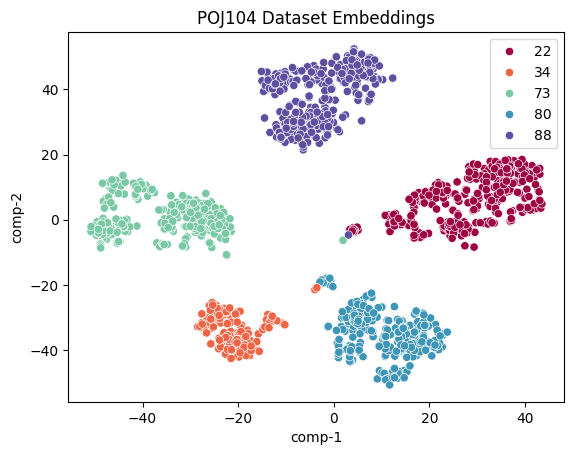

In [19]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.label.tolist(),
                palette=sns.color_palette("Spectral", as_cmap=True),
                data=df).set(title="POJ104 Dataset Embeddings")